## *Data Import*
### **Project Psychophysiology - winter semester 2024/25**

### Team NeuroUbahnismus

#### Seunghui Ko, Jonas Ebert, Luca Strasser




In [17]:
import neurokit2 as nk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def read_opensignals_data(filename):
    """Read OpenSignals data file and return timestamps and signals"""
    # Skip header lines
    header_lines = 0
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('#'):
                header_lines += 1
            else:
                break

    # Read data using pandas
    data = pd.read_csv(filename, skiprows=header_lines, delimiter='\t',
                      names=['nSeq', 'I1', 'I2', 'O1', 'O2', 'ECG', 'EDA'])

    # Reorder columns to match actual data
    data = data.rename(columns={'O2': 'ECG_temp', 'ECG': 'EDA_temp'})
    data['ECG'] = data['ECG_temp']
    data['EDA'] = data['EDA_temp']
    data = data.drop(['ECG_temp', 'EDA_temp'], axis=1)

    # Create sequential index for time calculation
    data = data.reset_index(drop=True)
    data['time_sec'] = data.index / 1000

    return data

def split_and_save_data(data, output_folder, participant):
    """Split data according to time ranges, transform, and save to CSV files"""
    conditions = {
        (60, 359): ('empty', 'bright'),    # 1min - 5min59s
        (360, 600): ('empty', 'dark'),     # 6min - 10min
        (1260, 1559): ('full', 'bright'),  # 21min - 26min59s
        (1560, 1800): ('full', 'dark')     # 26min - 30min
    }

    # Transformation parameters
    sampling_resolution = 10
    vcc = 3.3
    ecg_gain = 1100
    eda_conversion_factor = 0.132

    # Print overall statistics
    total_duration_sec = len(data) / 1000
    print(f"\nTotal samples: {len(data)}")
    print(f"Total duration: {total_duration_sec:.1f} seconds ({total_duration_sec/60:.1f} minutes)")

    for (start_sec, end_sec), (condition1, condition2) in conditions.items():
        # Calculate sample indices for the time range
        start_idx = int(start_sec * 1000)
        end_idx = int(end_sec * 1000)

        # Get data segment
        segment = data.iloc[start_idx:end_idx]

        print(f"\n{condition1}-{condition2}:")
        print(f"Time range {start_sec}-{end_sec} seconds")
        print(f"Number of samples: {len(segment)}")

        if len(segment) == 0:
            print(f"Warning: No data found for {participant} between {start_sec}-{end_sec} seconds")
            continue

        # Transform ECG data
        ecg_digital = segment['ECG']
        ecg_transformed = (ecg_digital / (2 ** sampling_resolution) - 0.5) * vcc / ecg_gain * 1000

        # Transform EDA data
        eda_digital = segment['EDA']
        eda_transformed = (eda_digital / (2 ** sampling_resolution)) * vcc / eda_conversion_factor

        # Create DataFrames for transformed data
        ecg_df = pd.DataFrame({
            "Time": segment['time_sec'],
            "ECG (mV)": ecg_transformed
        })

        eda_df = pd.DataFrame({
            "Time": segment['time_sec'],
            "EDA (µS)": eda_transformed
        })

        # Create output filenames
        output_filename_ecg = f"{output_folder}/{participant}_{condition1}-{condition2}_ecg.csv"
        output_filename_eda = f"{output_folder}/{participant}_{condition1}-{condition2}_eda.csv"

        # Save transformed data to CSV
        ecg_df.to_csv(output_filename_ecg, index=False)
        eda_df.to_csv(output_filename_eda, index=False)

        print(f"Wrote files {output_filename_ecg} and {output_filename_eda}")

def main():
    # File paths for input and output
    source_data_folder = '/Users/luca/Downloads/GitHub/Team_U-bahn/sourcedata'
    raw_data_folder = '/Users/luca/Downloads/GitHub/Team_U-bahn/rawdata'
    participants = ['sub-01', 'sub-02']

    # Create output directory if it doesn't exist
    os.makedirs(raw_data_folder, exist_ok=True)

    # Process each participant's data
    for participant in participants:
        # Read the long file
        filename = f"{source_data_folder}/{participant}_long.txt"

        try:
            # Read data
            data = read_opensignals_data(filename)

            # Debug information
            print(f"\nProcessing {filename}")
            print(f"Data shape: {data.shape}")
            print("\nFirst few rows:")
            print(data.head())

            # Split, transform, and save data
            split_and_save_data(data, raw_data_folder, participant)

        except FileNotFoundError:
            print(f"File not found: {filename}")
            continue
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            continue

if __name__ == "__main__":
    main()



Processing /Users/luca/Downloads/GitHub/Team_U-bahn/sourcedata/sub-01_long.txt
Data shape: (1931250, 7)

First few rows:
   nSeq  I1  I2  O1  EDA  ECG  time_sec
0     0   0   1   1  449  532     0.000
1     0   0   1   1  450  534     0.001
2     0   0   1   1  449  537     0.002
3     0   0   1   1  450  540     0.003
4     0   0   1   1  449  543     0.004

Total samples: 1931250
Total duration: 1931.2 seconds (32.2 minutes)

empty-bright:
Time range 60-359 seconds
Number of samples: 299000
Wrote files /Users/luca/Downloads/GitHub/Team_U-bahn/rawdata/sub-01_empty-bright_ecg.csv and /Users/luca/Downloads/GitHub/Team_U-bahn/rawdata/sub-01_empty-bright_eda.csv

empty-dark:
Time range 360-600 seconds
Number of samples: 240000
Wrote files /Users/luca/Downloads/GitHub/Team_U-bahn/rawdata/sub-01_empty-dark_ecg.csv and /Users/luca/Downloads/GitHub/Team_U-bahn/rawdata/sub-01_empty-dark_eda.csv

full-bright:
Time range 1260-1559 seconds
Number of samples: 299000
Wrote files /Users/luca/Downlo

## **Check rawdata with plots below**

Gefundene ECG-Dateien: ['sub-01_empty-bright_ecg.csv', 'sub-01_empty-dark_ecg.csv', 'sub-01_full-bright_ecg.csv', 'sub-01_full-dark_ecg.csv', 'sub-02_empty-bright_ecg.csv', 'sub-02_empty-dark_ecg.csv', 'sub-02_full-bright_ecg.csv', 'sub-02_full-dark_ecg.csv']
Gefundene EDA-Dateien: ['sub-01_empty-bright_eda.csv', 'sub-01_empty-dark_eda.csv', 'sub-01_full-bright_eda.csv', 'sub-01_full-dark_eda.csv', 'sub-02_empty-bright_eda.csv', 'sub-02_empty-dark_eda.csv', 'sub-02_full-bright_eda.csv', 'sub-02_full-dark_eda.csv']

Datei: sub-01_empty-bright_ecg.csv
Spalten: Index(['Time', 'ECG (mV)'], dtype='object')
     Time  ECG (mV)
0  60.000  0.070312
1  60.001  0.064453
2  60.002  0.064453
3  60.003  0.067383
4  60.004  0.070312

Datei: sub-01_empty-dark_ecg.csv
Spalten: Index(['Time', 'ECG (mV)'], dtype='object')
      Time  ECG (mV)
0  360.000  0.005859
1  360.001  0.002930
2  360.002  0.000000
3  360.003 -0.005859
4  360.004 -0.008789

Datei: sub-01_full-bright_ecg.csv
Spalten: Index(['Time',

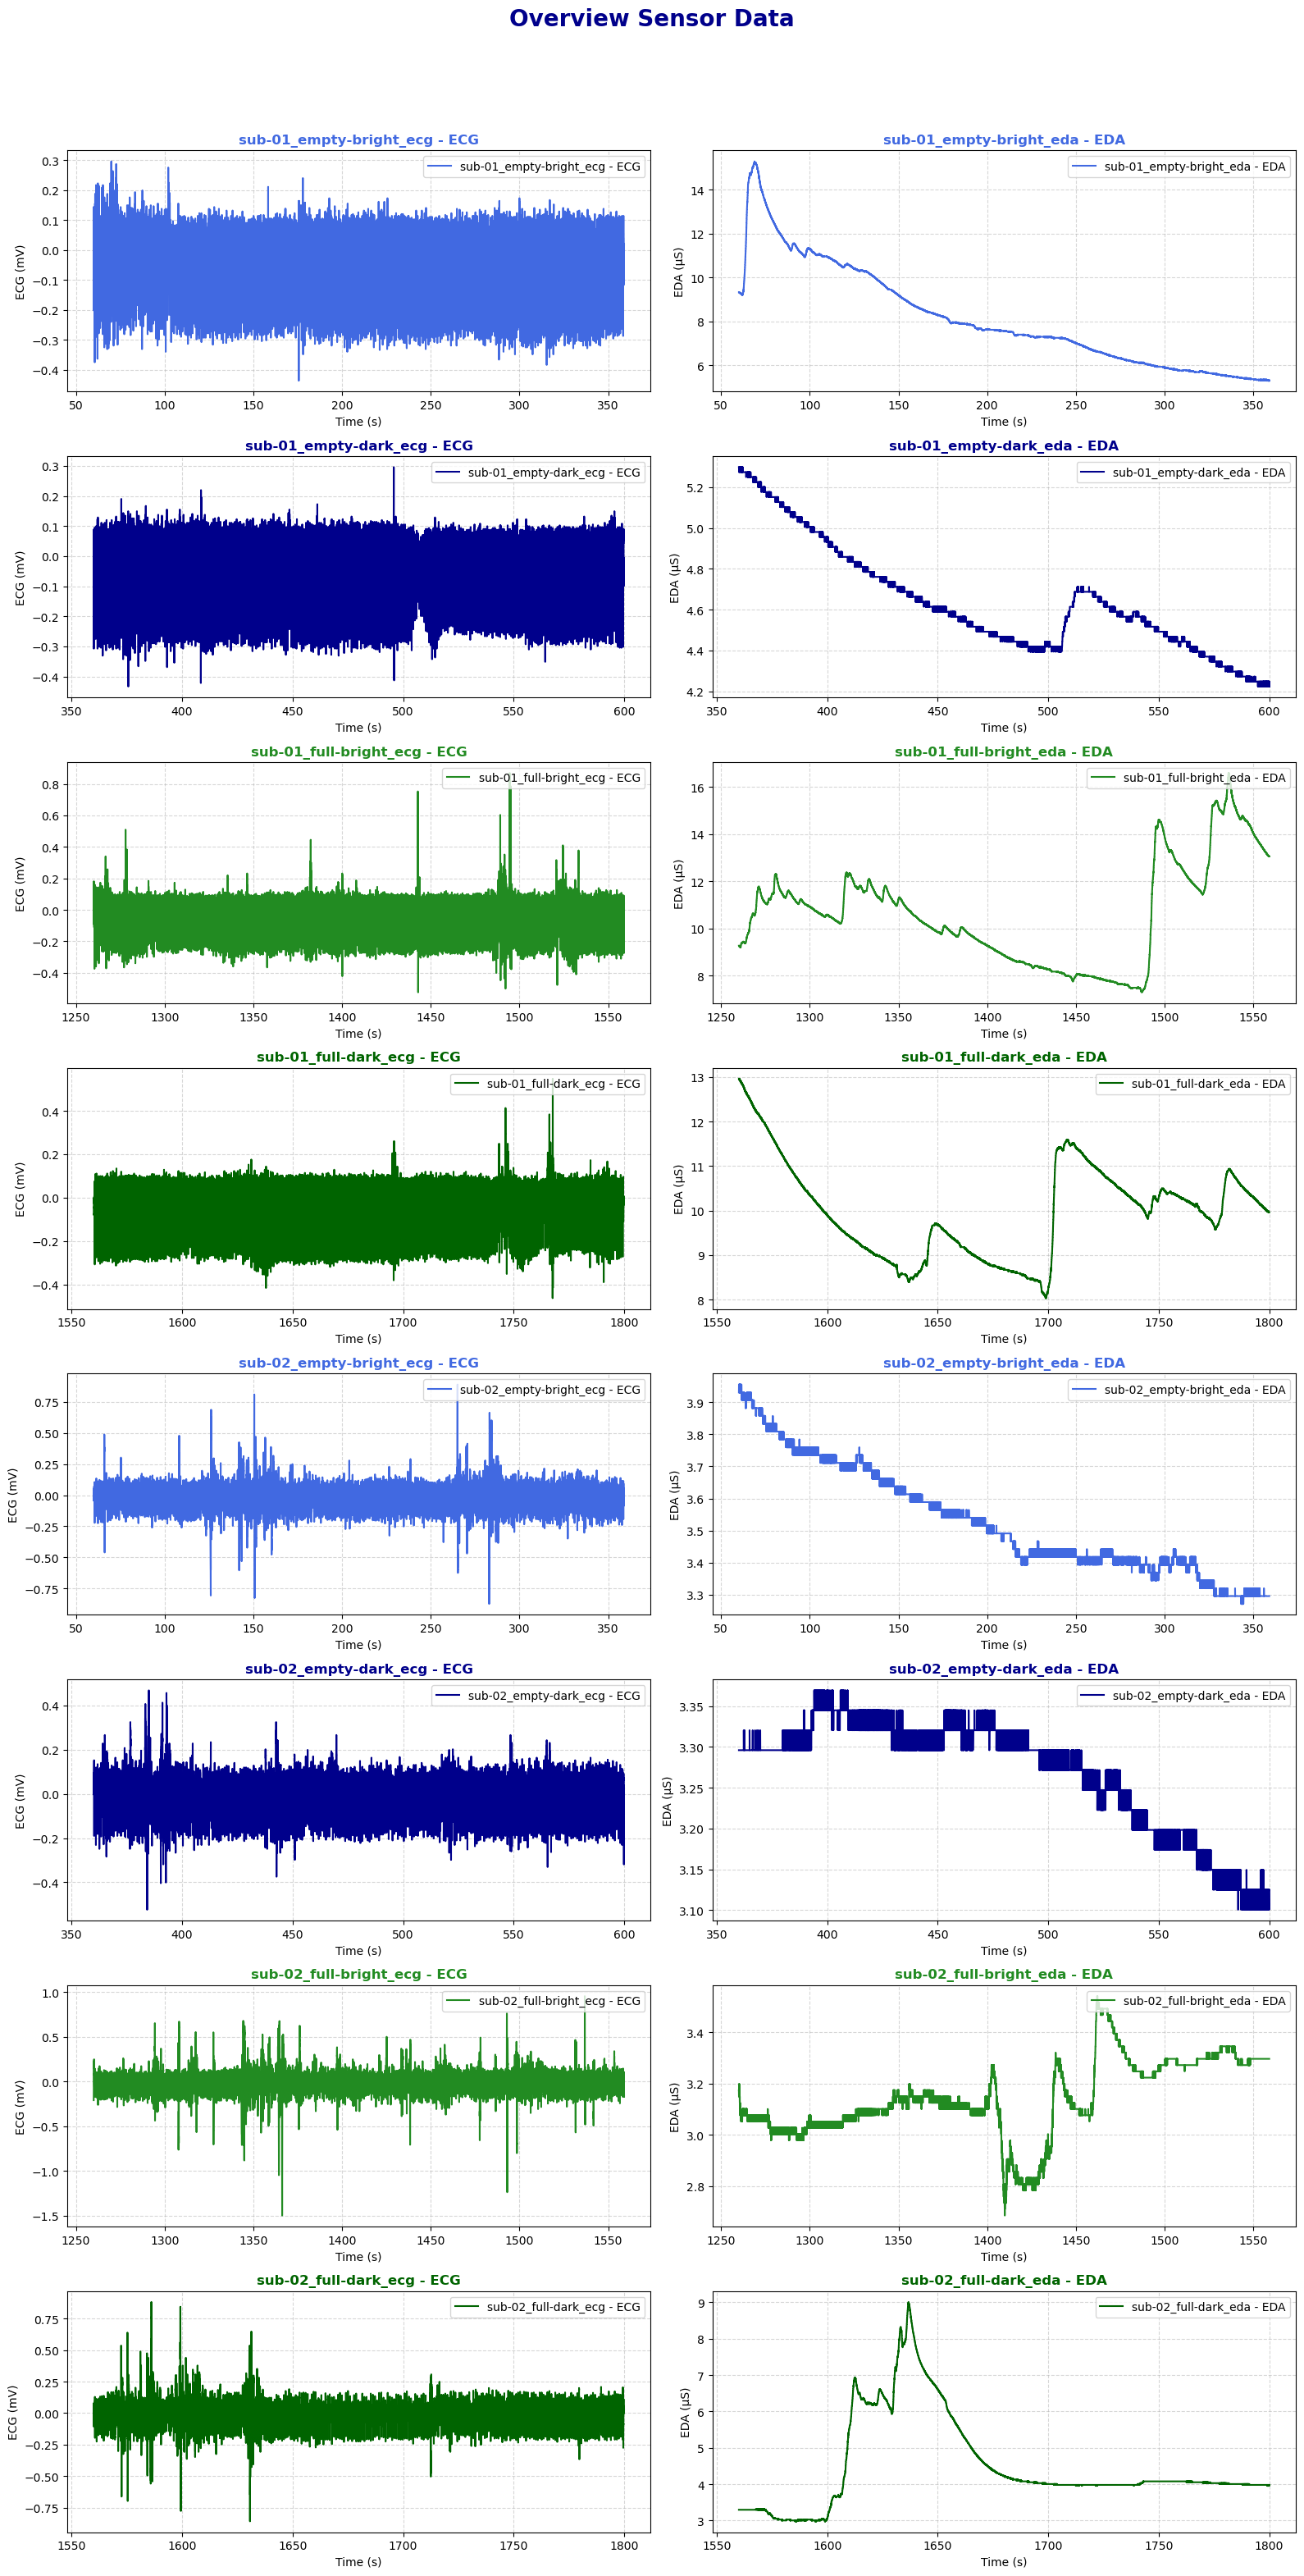

In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Ordner mit den Rohdaten
rawdata_folder = '/Users/luca/Downloads/GitHub/Team_U-bahn/rawdata'

# Hole alle Dateien im Ordner
ecg_files = sorted([f for f in os.listdir(rawdata_folder) if 'ecg' in f.lower() and f.endswith('.csv')])
eda_files = sorted([f for f in os.listdir(rawdata_folder) if 'eda' in f.lower() and f.endswith('.csv')])

# Debugging: Überprüfe Dateien und Spalten
print("Gefundene ECG-Dateien:", ecg_files)
print("Gefundene EDA-Dateien:", eda_files)

for file in ecg_files + eda_files:
    file_path = os.path.join(rawdata_folder, file)
    data = pd.read_csv(file_path)
    print(f"\nDatei: {file}")
    print("Spalten:", data.columns)
    print(data.head())

# Starte den Plot
num_files = max(len(ecg_files), len(eda_files))
fig, axes = plt.subplots(nrows=num_files, ncols=2, figsize=(16, 4 * num_files))
axes = axes.reshape(-1, 2)  # Sicherheitshalber Achsen neu formatieren

# Hauptüberschrift
fig.suptitle("Overview Sensor Data", fontsize=20, fontweight='bold', color='darkblue')

# Farbzuweisung pro Bedingung
condition_colors = {
    'empty-bright': 'royalblue',
    'empty-dark': 'darkblue',
    'full-bright': 'forestgreen',
    'full-dark': 'darkgreen'
}

# Plot ECG-Daten
for idx, file in enumerate(ecg_files):
    file_path = os.path.join(rawdata_folder, file)
    data = pd.read_csv(file_path)

    # Bedingung aus dem Dateinamen extrahieren
    condition = '-'.join(file.split('_')[1].split('-')[:2])  # z.B., 'empty-bright'
    color = condition_colors.get(condition, 'black')  # Farbe für die Bedingung

    if 'Time' in data.columns and 'ECG (mV)' in data.columns:
        time_values = data['Time']
        ecg_values = data['ECG (mV)']

        ax_ecg = axes[idx, 0]
        ax_ecg.plot(time_values, ecg_values, label=f"{file.split('.')[0]} - ECG", color=color)
        ax_ecg.set_title(f"{file.split('.')[0]} - ECG", fontsize=12, fontweight='bold', color=color)
        ax_ecg.set_xlabel("Time (s)")
        ax_ecg.set_ylabel("ECG (mV)")
        ax_ecg.legend(fontsize=10, loc='upper right')
        ax_ecg.grid(True, linestyle='--', alpha=0.5)

# Plot EDA-Daten
for idx, file in enumerate(eda_files):
    file_path = os.path.join(rawdata_folder, file)
    data = pd.read_csv(file_path)

    # Bedingung aus dem Dateinamen extrahieren
    condition = '-'.join(file.split('_')[1].split('-')[:2])  # z.B., 'empty-bright'
    color = condition_colors.get(condition, 'black')  # Farbe für die Bedingung

    if 'Time' in data.columns and 'EDA (µS)' in data.columns:
        time_values = data['Time']
        eda_values = data['EDA (µS)']

        ax_eda = axes[idx, 1]
        ax_eda.plot(time_values, eda_values, label=f"{file.split('.')[0]} - EDA", color=color)
        ax_eda.set_title(f"{file.split('.')[0]} - EDA", fontsize=12, fontweight='bold', color=color)
        ax_eda.set_xlabel("Time (s)")
        ax_eda.set_ylabel("EDA (µS)")
        ax_eda.legend(fontsize=10, loc='upper right')
        ax_eda.grid(True, linestyle='--', alpha=0.5)

# Layout anpassen
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Platz für die Hauptüberschrift lassen
plt.show()
